# Creating TF Record Dataset

Expalantion of how to create a TensorFlow Record based dataset.  Code is from https://github.com/tensorflow/models/blob/master/slim/datasets/download_and_convert_cifar10.py

In [1]:
import os
import sys
sys.path.append('../python')
import tarfile

import numpy as np
from six.moves import cPickle
from six.moves import urllib
import tensorflow as tf

import dataset_utils

Some parameters:

In [2]:
# The URL where the CIFAR data can be downloaded.
_DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# The number of training files.
_NUM_TRAIN_FILES = 5

# The height and width of each image.
_IMAGE_SIZE = 32

# The names of the classes.
_CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

This function loads the cifar10 data from a python pickle and then writes the image out as a TensorFlow record.

In [3]:
def _add_to_tfrecord(filename, tfrecord_writer, offset=0):
    """Loads data from the cifar10 pickle files and writes files to a TFRecord.
    Args:
    filename: The filename of the cifar10 pickle file.
    tfrecord_writer: The TFRecord writer to use for writing.
    offset: An offset into the absolute number of images previously written.
    Returns:
    The new offset.
    """
    
    ## Load the dataset here - in this case it is a pickled python dictionary containing the images and the
    ## labels
    with tf.gfile.Open(filename, 'rb') as f:
        if sys.version_info < (3,):
            data = cPickle.load(f)
        else:
            data = cPickle.load(f, encoding='bytes')

    images = data[b'data']
    num_images = images.shape[0]

    images = images.reshape((num_images, 3, 32, 32))
    labels = data[b'labels']
    
    ## set up the computation graph
    with tf.Graph().as_default():
        ## create an image placeholder 
        image_placeholder = tf.placeholder(dtype=tf.uint8)
        ## the output images will be in png format, this sets this up
        encoded_image = tf.image.encode_png(image_placeholder)
        ## start a session
        with tf.Session('') as sess:
            ## loop over the images in the file
            for j in range(num_images):
                sys.stdout.write('\r>> Reading file [%s] image %d/%d' % (
                    filename, offset + j + 1, offset + num_images))
                sys.stdout.flush()

                image = np.squeeze(images[j]).transpose((1, 2, 0))
                label = labels[j]
                ## converts image to png here
                png_string = sess.run(encoded_image,
                                      feed_dict={image_placeholder: image})
                
#                 example = 
                ## creates tf_example (see dataset_utils.py)
                example = dataset_utils.image_to_tfexample(
                    png_string, b'png', _IMAGE_SIZE, _IMAGE_SIZE, label)
                ## write to the tensorflow record
                tfrecord_writer.write(example.SerializeToString())
    ##keep track of the offset
    return offset + num_images


In [5]:
def run(dataset_dir):
    """Runs the download and conversion operation.
    Args:
    dataset_dir: The dataset directory where the dataset is stored.
    """
    ## note: tf.gfile is used instead of python standard library functions as it is more portable 
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

    training_filename = _get_output_filename(dataset_dir, 'train')
    testing_filename = _get_output_filename(dataset_dir, 'test')

    if tf.gfile.Exists(training_filename) and tf.gfile.Exists(testing_filename):
        print('Dataset files already exist. Exiting without re-creating them.')
        
        return

    dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)

    # First, process the training data:
    with tf.python_io.TFRecordWriter(training_filename) as tfrecord_writer:
        offset = 0
        for i in range(_NUM_TRAIN_FILES):
            filename = os.path.join(dataset_dir,
                              'cifar-10-batches-py',
                              'data_batch_%d' % (i + 1))  # 1-indexed.
            offset = _add_to_tfrecord(filename, tfrecord_writer, offset)

    # Next, process the testing data:
    with tf.python_io.TFRecordWriter(testing_filename) as tfrecord_writer:
        filename = os.path.join(dataset_dir,
                            'cifar-10-batches-py',
                            'test_batch')
        _add_to_tfrecord(filename, tfrecord_writer)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(_CLASS_NAMES)), _CLASS_NAMES))
    dataset_utils.write_label_file(labels_to_class_names, dataset_dir)

    _clean_up_temporary_files(dataset_dir)
    
    print('\nFinished converting the Cifar10 dataset!')

Some helper functions

In [7]:
def _get_output_filename(dataset_dir, split_name):
    """Creates the output filename.
    Args:
    dataset_dir: The dataset directory where the dataset is stored.
    split_name: The name of the train/test split.
    Returns:
    An absolute file path.
    """
    return '%s/cifar10_%s.tfrecord' % (dataset_dir, split_name)


def _download_and_uncompress_dataset(dataset_dir):
    """Downloads cifar10 and uncompresses it locally.
    Args:
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = _DATA_URL.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
              filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(_DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dataset_dir)


def _clean_up_temporary_files(dataset_dir):
    """Removes temporary files used to create the dataset.
    Args:
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = _DATA_URL.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)
    tf.gfile.Remove(filepath)

    tmp_dir = os.path.join(dataset_dir, 'cifar-10-batches-py')
    tf.gfile.DeleteRecursively(tmp_dir)


In [8]:
dataset_dir = '../data/cifar10_data/'
run(dataset_dir)

>> Downloading cifar-10-python.tar.gz 100.0%
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
>> Reading file [../data/cifar10_data/cifar-10-batches-py/test_batch] image 10000/1000000
Finished converting the Cifar10 dataset!


# Loading the TF record into a Dataset

In [78]:

def _parse_function(example_proto):
    features={
      'image/encoded': tf.FixedLenFeature([], tf.string, default_value=""),
      'image/format': tf.FixedLenFeature([], tf.string, default_value=""),
      'image/class/label': tf.FixedLenFeature([], tf.int64, default_value=0),
      'image/height': tf.FixedLenFeature([], tf.int64, default_value=0),
      'image/width': tf.FixedLenFeature([], tf.int64, default_value=0),
    }
    parsed_features = tf.parse_single_example(example_proto, features)
#     print(parsed_features)
#     print(parsed_features["image/encoded"])
#     print(parsed_features["image/class/label"])
#     stop
    image = tf.image.decode_png(parsed_features["image/encoded"], dtype=tf.uint8, channels=3)
    return image, parsed_features["image/class/label"], parsed_features["image/format"]

In [80]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.contrib.data.TFRecordDataset(filenames)
dataset = dataset.map(_parse_function)  # Parse the record into tensors.
dataset = dataset.repeat(1)  # Repeat the input once
dataset = dataset.batch(1)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.

# Initialize `iterator` with training data.
with tf.Session('') as sess:
    training_filenames = ["../data/cifar10_data/cifar10_train.tfrecord"]
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    for i in range(1):
        value = sess.run(next_element)
        print(value)
        print(value[0].shape)
# with tf.Session('') as sess:
#     # Initialize `iterator` with validation data.
#     validation_filenames = ["../data/cifar10_data/cifar10_test.tfrecord"]
#     sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})

(array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ..., 
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ..., 
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ..., 
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ..., 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ..., 
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ..., 
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ..., 
         [216, 184, 140],
 

In [58]:
%matplotlib inline

In [59]:
import matplotlib.pyplot as plt

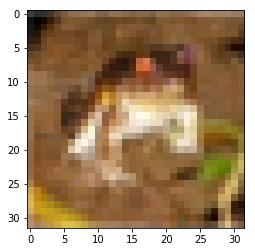

In [81]:
plt.imshow(np.squeeze(value[0]))

In [64]:
value[0][0,0:32*32].reshape(32,32)

array([[137,  80,  78, ..., 252,  24, 237],
       [163,   0,   0, ..., 189, 124, 110],
       [108,  76, 226, ...,  81,  16, 193],
       ..., 
       [234, 114, 179, ..., 212, 171, 211],
       [  5, 161, 145, ...,  80, 134, 240],
       [213, 226, 140, ...,  65, 238, 136]], dtype=uint8)

In [ ]:
valu